In [2]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [4]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [5]:
# raw_data = pd.read_csv("data/heart.csv")
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()

raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)


original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,oldpeak
0,63,1,1,145,233,1,2,150,0,3,0,6,2.3
1,67,1,4,160,286,0,2,108,1,2,3,3,1.5
2,67,1,4,120,229,0,2,129,1,2,2,7,2.6
3,37,1,3,130,250,0,0,187,0,3,0,3,3.5
4,41,0,2,130,204,0,2,172,0,1,0,3,1.4


In [6]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 25, activation=activation, input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation=activation,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [7]:
## Need to define a scaling function that ignores categorical values...?

In [13]:
nn = build_dnn(num_features=original_data.shape[1], activation="relu")
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                350       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________


In [14]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [15]:
# ZScaler.transform(X_train)

In [16]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer, analyzer_type="pattern.attribution")

In [17]:
pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.457, Acc:0.8643
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.421 accuracy=0.9286
Fold Correct: 26
Epoch 1/1
12/12 [==============================] - 0s 16ms/step - loss: 3.3155 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000
Running worker: 1
Fold: 1 -> Loss:0.435, Acc:0.8915
Prediction Accuracy
28/28 [==============================] - 0s 25us/step
Scores on data set: loss=0.508 accuracy=0.8571
Fold Correct: 24
Epoch 1/1
12/12 [==============================] - 0s 19ms/step - loss: 3.3213 - broadcast_4_loss: 1.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000
Running worker: 2
Fold: 2 -> Loss:0.468, Acc:0.8721
Prediction Accuracy
28/28 [==============================] - 0s 21us/step
Scores on data set: loss=0.729 accuracy=0.8571
Fold Correct: 24
Epoch 1/1
12/12 [==============================] - 0s 23ms/step - loss: 3.3188 -

Confusion matrix, without normalization
[[0.85416667 0.14583333]
 [0.20325203 0.79674797]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a40c76898>, array([[123,  21],
        [ 25,  98]]))

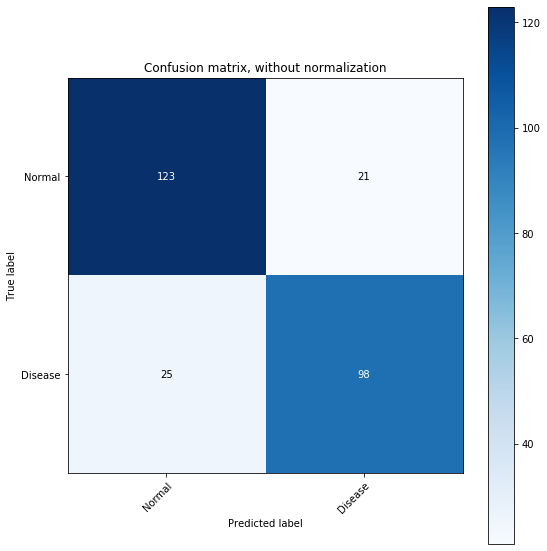

In [18]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [19]:
pipeline.reducer_pipeline = Pipeline([
                                ("umap", umap.UMAP(random_state=42,
                                                n_components = 10,
                                                n_neighbors=15,
                                                min_dist=0)),
                               ("scaler", MinMaxScaler())
                            ])
pipeline.train_clusterer(plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.112245,0.301151,0.44657
"(13, 12)",2,0.112245,0.301151,0.44657
"(13, 13)",2,0.112245,0.301151,0.44657
"(14, 12)",2,0.112245,0.301151,0.44657
"(14, 13)",2,0.112245,0.301151,0.44657
"(14, 14)",2,0.112245,0.301151,0.44657
"(15, 12)",2,0.112245,0.301151,0.44657
"(15, 13)",2,0.112245,0.301151,0.44657
"(15, 14)",2,0.112245,0.301151,0.44657
"(15, 15)",2,0.112245,0.301151,0.44657


In [20]:
pd.Series(pipeline.clusterer.labels_).value_counts()

 0    48
 1    39
-1    11
dtype: int64

In [21]:
# pipeline.reducer_pipeline

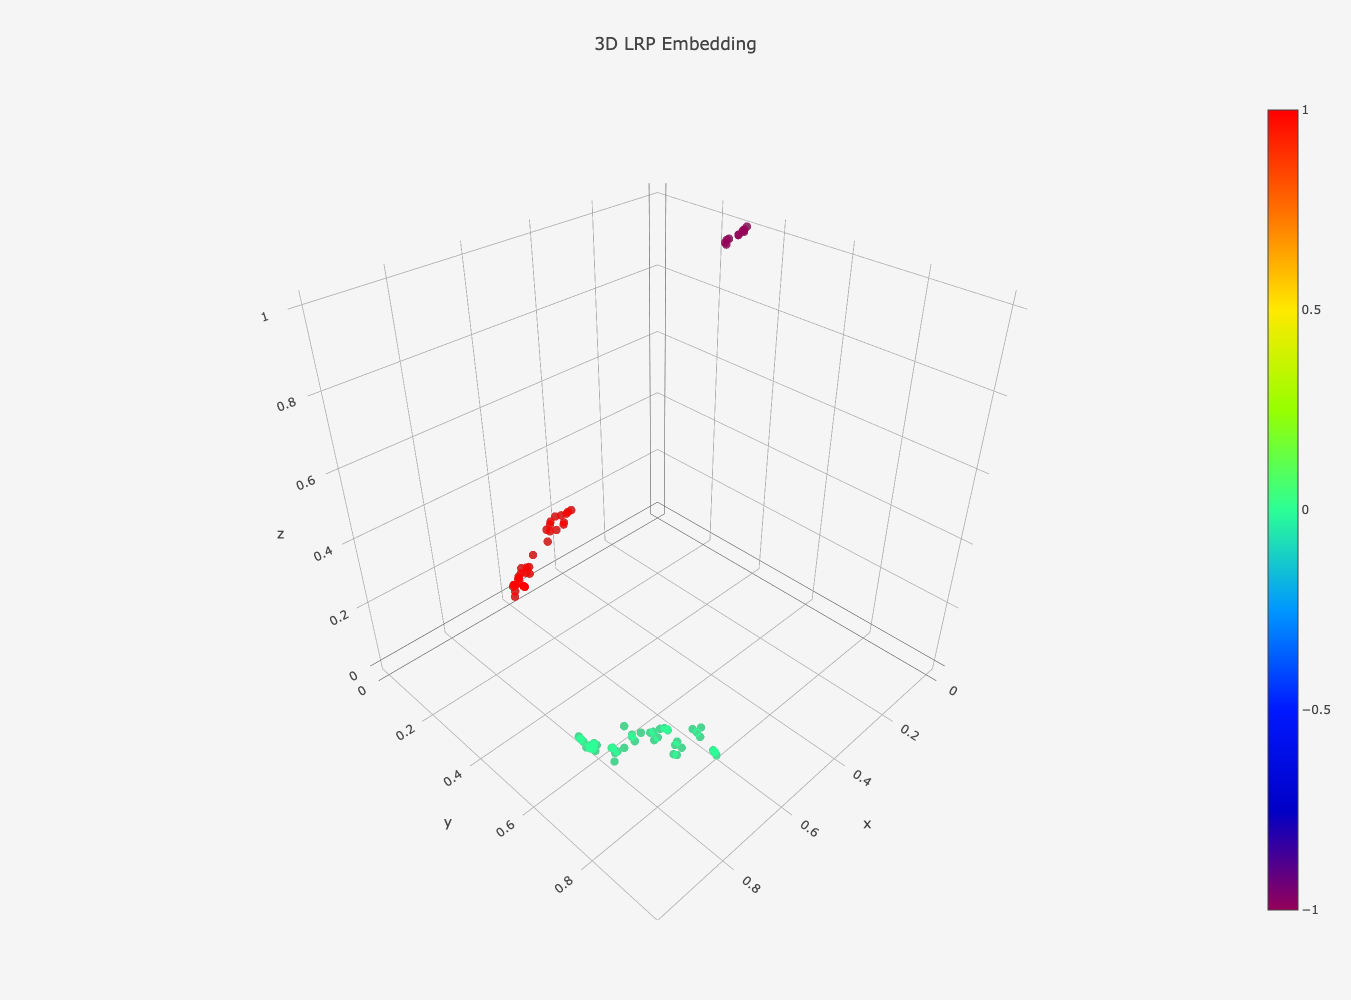

In [22]:
import umap
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=15,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])

training_lrp = pipeline.training_lrp
embedding_pipeline.fit(training_lrp)
embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8,
        showscale=True
    ),
    text=pipeline.clusterer.labels_
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')

In [23]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Epoch 1/1
13/13 [==============================] - 1s 49ms/step - loss: 3.3165 - broadcast_31_loss: 1.0000 - broadcast_32_loss: 1.0000 - broadcast_33_loss: 1.0000
Epoch 1/1
13/13 [==============================] - 1s 51ms/step - loss: 3.3226 - broadcast_34_loss: 1.0000 - broadcast_35_loss: 1.0000 - broadcast_36_loss: 1.0000
Epoch 1/1
13/13 [==============================] - 1s 55ms/step - loss: 3.3208 - broadcast_37_loss: 1.0000 - broadcast_38_loss: 1.0000 - broadcast_39_loss: 1.0000
Epoch 1/1
13/13 [==============================] - 1s 56ms/step - loss: 3.3172 - broadcast_40_loss: 1.0000 - broadcast_41_loss: 1.0000 - broadcast_42_loss: 1.0000
Epoch 1/1
13/13 [==============================] - 1s 59ms/step - loss: 3.3329 - broadcast_43_loss: 1.0000 - broadcast_44_loss: 1.0000 - broadcast_45_loss: 1.0000
Epoch 1/1
13/13 [==============================] - 1s 61ms/step - loss: 3.3218 - broadcast_46_loss: 1.0000 - broadcast_47_loss: 1.0000 - broadcast_48_loss: 1.00

In [24]:
pd.Series(cluster_labels).value_counts()

1    9
dtype: int64

## Plotting Testing LRP

In [25]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [26]:
len(training_lrp)

98

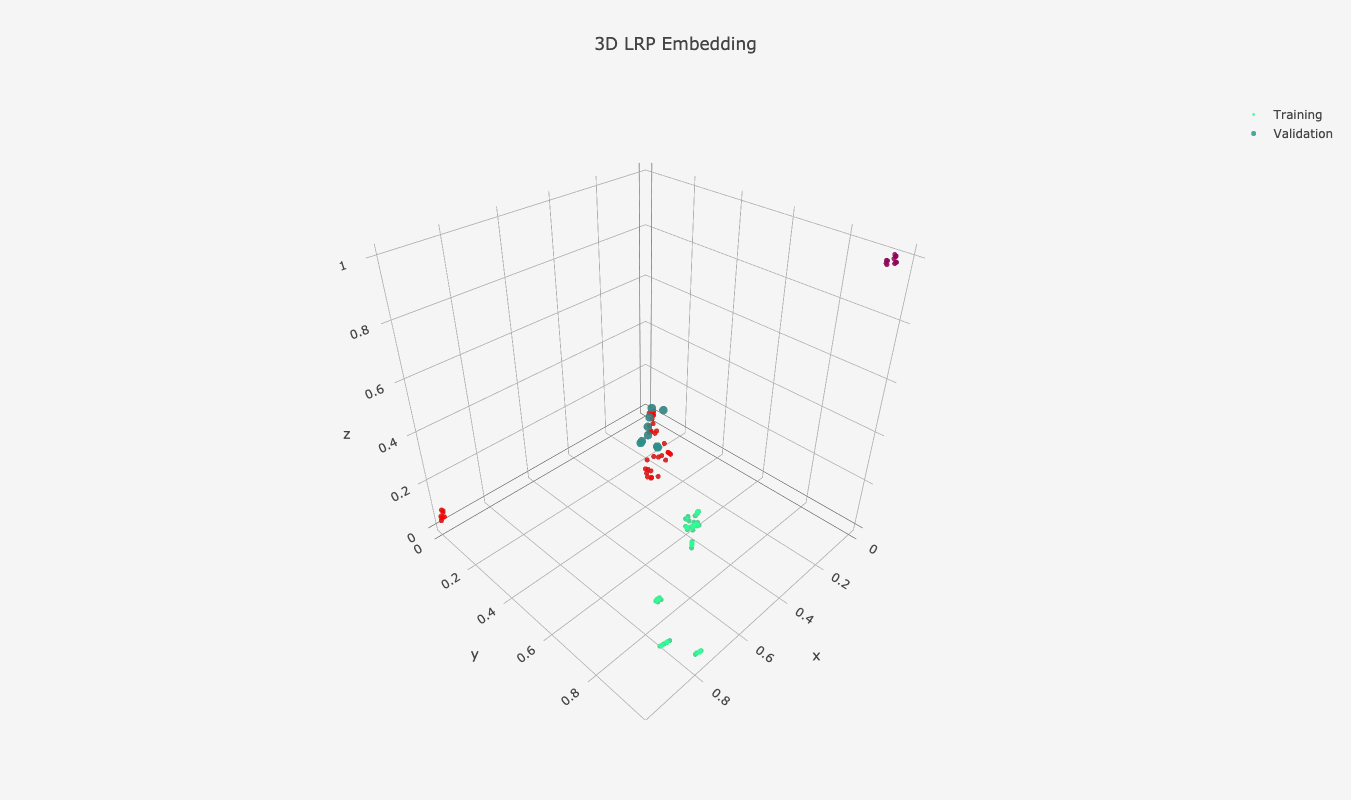

In [27]:
import umap
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline

embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=3,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=800,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')

# Comparing Subclusters to Original Data

In [28]:
y_train.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [29]:
original_y = original_labels[y_train.index]
original_y.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [30]:
y_train.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr].head()

122    1
24     1
137    1
184    0
260    0
Name: target, dtype: int64

In [31]:
# Get testing samples from cross validation
# That were correctly predicted
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class

correct_original_target = original_y.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr][split_class]

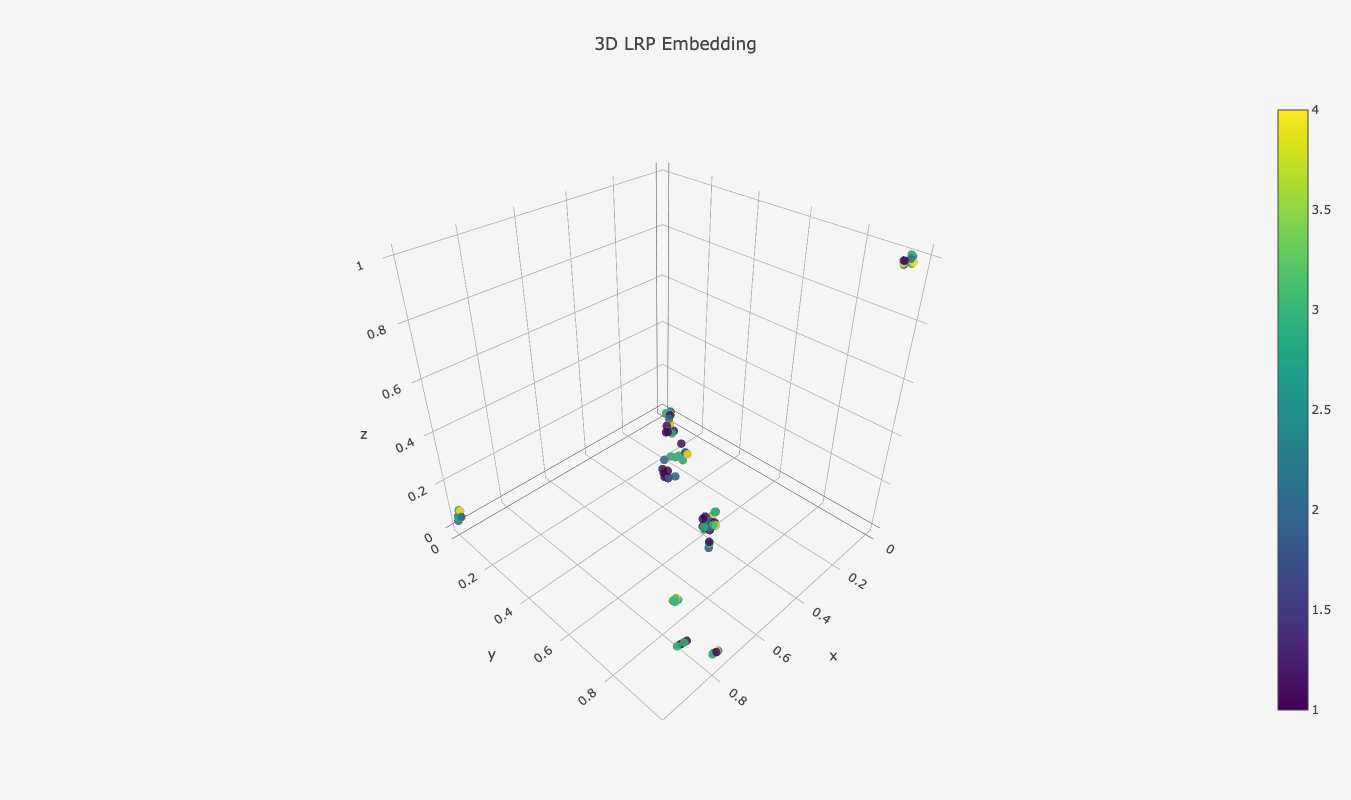

In [32]:
emb3d["text"] = correct_original_target
emb3d["marker"]["color"] = correct_original_target
emb3d["marker"]["showscale"] = True
emb3d["marker"]["size"] = 5
emb3d["marker"]["colorscale"] = "Viridis"

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-vs-original.html')

In [33]:
from sklearn import metrics
metrics.adjusted_rand_score(correct_original_target, pipeline.clusterer.labels_)

0.00392704801796359

In [34]:
relevance_embedding = embedding#pipeline.reducer_pipeline.transform(pipeline.training_lrp)
relevance_embedding.shape

(98, 3)

In [39]:
from scipy.stats import entropy

nsamples = len(relevance_embedding)

# nbins  = 30
# xedges = np.linspace(0,1,nbins+1)
# yedges = np.linspace(0,1,nbins+1)
# zedges = np.linspace(0,1,nbins+1)

# axes_ = [x.ravel() for x in np.meshgrid(xedges,yedges,zedges)]

# grid = np.array([x for x in zip(*axes_)])

nbins  = 200
grid, edges = np.histogramdd(relevance_embedding, bins=nbins)
densities = (grid/nsamples).flatten()

In [40]:
entropy(densities)

4.514238174531799